# 1.獲得関数の定義

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import ncx2

def l2_lcb(means: np.ndarray,
                 variances: np.ndarray,
                 target: np.ndarray,
                 p: float = 0.05,
                 eps: float = 1e-8) -> np.ndarray:
    k = means.shape[1]
    gamma2 = np.maximum(variances.mean(axis=1), eps)
    diff2 = np.sum((means - target)**2, axis=1)
    lam = diff2 / gamma2
    q = ncx2.ppf(1 - p, df=k, nc=lam)
    q = np.nan_to_num(q, nan=0.0, posinf=0.0, neginf=0.0)
    lower_bound = gamma2 * q
    return -lower_bound

def l2_ei(means, vars_, target, y_min, eps=1e-8):
    k = means.shape[1]
    gamma2 = np.maximum(vars_.mean(axis=1), eps)
    diff2 = np.sum((means - target)**2, axis=1)
    nc = diff2 / gamma2
    x = y_min / gamma2
    t1 = y_min * ncx2.cdf(x, df=k, nc=nc)
    t2 = gamma2 * (k * ncx2.cdf(x, df=k+2, nc=nc) + nc * ncx2.cdf(x, df=k+4, nc=nc))
    return np.maximum(0, t1 - t2)

# 2.dfの準備

In [2]:
input = "/Users/kaker/OneDrive - YNU(ynu.jp)/大学用/lab/VScode/多目的最適化の理論構築/train/result0.xlsx"
df_all = pd.read_excel(input)

X_cols = ["F12","F13","F14","F15","F16","F20","F0","R12","R13","R14","R15","R16","R20","R0"]
y_cols_m = ["mwave1", "mstrength1"]
y_cols_d = ["dwave1", "dstrength1"]

# 3.小・中・大規模データセット作成

In [8]:
s_ratio = 0.1
m_ratio = 0.3
l_ratio = 0.6
df_small = df_all.sample(frac=s_ratio, random_state=0)
df_medium = df_all.sample(frac=m_ratio, random_state=0)
df_large = df_all.sample(frac=l_ratio, random_state=0)

df_small = df_small.reset_index(drop=True)
df_medium = df_medium.reset_index(drop=True)
df_large = df_large.reset_index(drop=True)

print(f"Small dataset size: {df_small.shape[0]}")
print(f"Medium dataset size: {df_medium.shape[0]}")
print(f"Large dataset size: {df_large.shape[0]}")

Small dataset size: 26
Medium dataset size: 77
Large dataset size: 154


# 4.網羅的探索関数の定義

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import GPy
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from scipy.stats import ncx2
import warnings

warnings.filterwarnings("ignore")

def l2_lcb_exact(means: np.ndarray,
                 variances: np.ndarray,
                 target: np.ndarray,
                 p: float = 0.05,
                 eps: float = 1e-8) -> np.ndarray:
    """
    L2-LCB acquisition: returns -lower_bound (larger → more exploratory)
    """
    k = means.shape[1]
    gamma2 = np.maximum(variances.mean(axis=1), eps)
    diff2 = np.sum((means - target)**2, axis=1)
    lam   = diff2 / gamma2
    q     = ncx2.ppf(1 - p, df=k, nc=lam)
    q     = np.nan_to_num(q, nan=0.0, posinf=0.0, neginf=0.0)
    return -gamma2 * q

def l2_ei(means: np.ndarray,
          variances: np.ndarray,
          target: np.ndarray,
          y_min: float,
          eps: float = 1e-8) -> np.ndarray:
    """
    L2-Expected Improvement acquisition
    """
    k      = means.shape[1]
    gamma2 = np.maximum(variances.mean(axis=1), eps)
    diff2  = np.sum((means - target)**2, axis=1)
    nc     = diff2 / gamma2
    x      = y_min / gamma2
    t1     = y_min * ncx2.cdf(x, df=k,   nc=nc)
    t2     = gamma2 * (
              k   * ncx2.cdf(x, df=k+2, nc=nc)
            + nc  * ncx2.cdf(x, df=k+4, nc=nc)
          )
    return np.maximum(0, t1 - t2)

def fit_multi_gpy(X: np.ndarray, Y: np.ndarray):
    """
    Train independent GPRegression (Matern52 ARD) for each output.
    """
    models = []
    for i in range(Y.shape[1]):
        kern = GPy.kern.Exponential(input_dim=X.shape[1], ARD=True)
        m    = GPy.models.GPRegression(X, Y[:, [i]], kern)
        m.Gaussian_noise.variance = 1e-6
        m.Gaussian_noise.variance.fix()
        m.optimize(messages=False, max_iters=10)
        models.append(m)
    return models

def predict_multi_gpy(models, X: np.ndarray):
    """
    Returns (means, variances) both shape (n_samples, n_outputs).
    """
    mus, vars_ = [], []
    for m in models:
        mu, var = m.predict(X)
        mus.append(mu.flatten())
        vars_.append(var.flatten())
    return np.column_stack(mus), np.column_stack(vars_)

def active_learning_loocv_on_acquired(
    train_df: pd.DataFrame,
    cand_df: pd.DataFrame,
    X_cols: list,
    Y_cols: list,
    target: np.ndarray,
    acquisition: str = 'lcb',
    p: float = 0.05,
    budget: int = None,
    skip_initial: int = 10,
    seed: int = 0
) -> pd.DataFrame:
    """
    Active learning + LOOCV R² on acquired samples.
    ① 再現性: seedでRNG固定
    ② 各目的ごとのR²を multioutput='raw_values' で取得
    """
    # データコピー＆reset
    train_df = train_df.copy().reset_index(drop=True)
    cand_df  = cand_df.copy().reset_index(drop=True)
    acquired_df = pd.DataFrame(columns=train_df.columns)

    # RNG初期化
    rng = np.random.RandomState(seed)

    n_iter = budget if budget is not None else len(cand_df)
    n_obj  = len(Y_cols)
    loocv_r2_list = []

    for it in range(1, n_iter + 1):
        # 学習データでGPフィット
        Xtr = train_df[X_cols].values
        Ytr = train_df[Y_cols].values
        scl = StandardScaler().fit(Ytr)
        Ytr_s = scl.transform(Ytr)
        tgt_s  = scl.transform(target.reshape(1, -1)).flatten()

        models = fit_multi_gpy(Xtr, Ytr_s)
        Xcand, _ = cand_df[X_cols].values, None
        mus, vars_ = predict_multi_gpy(models, Xcand)

        if acquisition == 'lcb':
            scores = l2_lcb_exact(mus, vars_, tgt_s, p)
        elif acquisition == 'ei':
            y_min  = np.min(np.sum((Ytr_s - tgt_s)**2, axis=1))
            scores = l2_ei(mus, vars_, tgt_s, y_min)
        else:  # 'rand'
            scores = rng.rand(len(cand_df))

        # 次点選択・追加
        idx_pick   = int(np.argmax(scores))
        new_sample = cand_df.iloc[[idx_pick]]
        cand_df = cand_df.drop(cand_df.index[idx_pick]).reset_index(drop=True)
        acquired_df = pd.concat([acquired_df, new_sample], ignore_index=True)
        train_df    = pd.concat([train_df, new_sample], ignore_index=True)

        # LOOCV R²
        if len(acquired_df) <= skip_initial:
            loocv_r2_list.append([np.nan] * n_obj)
            continue

        y_true_list, y_pred_list = [], []
        for j in range(len(acquired_df)):
            df_loo = acquired_df.drop(index=j).reset_index(drop=True)
            X_loo  = df_loo[X_cols].values
            Y_loo  = df_loo[Y_cols].values
            scl_loo= StandardScaler().fit(Y_loo)
            Y_loo_s= scl_loo.transform(Y_loo)

            models_loo = fit_multi_gpy(X_loo, Y_loo_s)
            x_test     = acquired_df.iloc[[j]][X_cols].values
            mu_s, _    = predict_multi_gpy(models_loo, x_test)
            mu_orig    = scl_loo.inverse_transform(mu_s).flatten()

            y_true_list.append(acquired_df.iloc[j][Y_cols].values)
            y_pred_list.append(mu_orig)

        Y_true_all = np.vstack(y_true_list)
        Y_pred_all = np.vstack(y_pred_list)
        # 各出力ごとのR²を返す
        r2_arr = r2_score(Y_true_all, Y_pred_all, multioutput='raw_values')
        loocv_r2_list.append(r2_arr)

    # DataFrame化
    df_loocv = pd.DataFrame(
        np.vstack(loocv_r2_list),
        columns=Y_cols,
        index=np.arange(1, n_iter + 1)
    )
    return df_loocv

def plot_acquired_loocv(df_loocv: pd.DataFrame):
    """
    各目的関数ごとに折れ線プロット
    """
    for col in df_loocv.columns:
        plt.figure(figsize=(6,4))
        plt.plot(df_loocv.index, df_loocv[col], marker='o')
        plt.xlabel("Iteration")
        plt.ylabel(f"LOOCV R² ({col})")
        plt.title(f"LOOCV R² on Acquired: {col}")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# --- 使用例 ---
# df_loocv = active_learning_loocv_on_acquired(
#     train_df     = df_small,
#     cand_df      = df_medium,
#     X_cols       = X_cols,
#     Y_cols       = Y_cols,
#     target       = np.array([330.64, 0.5]),
#     acquisition  = 'lcb',
#     p            = 0.7,
#     budget       = 100,
#     skip_initial = 10,
#     seed         = 42
# )
# plot_acquired_loocv(df_loocv)


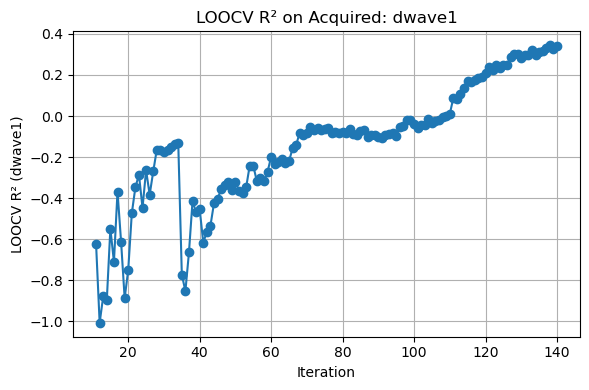

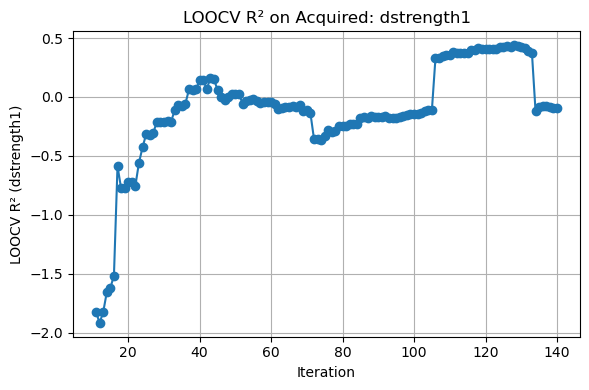

In [16]:
import pandas as pd
import numpy as np

# --- １．データ読み込み（例として Excel） ---


# --- ２．特徴量・目的変数・ターゲット定義 ---
X_cols = ["F12","F13","F14","F15","F16","F20","F0",
          "R12","R13","R14","R15","R16","R20","R0"]
Y_cols = ["dwave1","dstrength1"]
target = np.array([530.64, 0.005])
# --- ３．LOOCV付きアクティブラーニング実行 ---
#   skip_initial: 最初の n 点は LOOCV 計算をスキップ
#   seed: 乱数シード（再現性確保）
df_loocv = active_learning_loocv_on_acquired(
    train_df        = df_medium,  # 小データを学習用に使用
    cand_df         = df_large,  # 中データを候補プールに使用
    X_cols          = X_cols,
    Y_cols          = Y_cols,
    target          = target,
    acquisition     = 'lcb',      # 'lcb' or 'ei' or 'rand'
    p               = 0.7,        # LCB の信頼度パラメータ
    budget          = 140,        # 最大取得回数
    skip_initial    = 10,         # LOOCV 開始までの取得数
    seed            = 42          # 再現性のための乱数シード
)

# df_loocv は DataFrame:
#      iteration | mwave1 | mstrength1
#      -----------------------------
#           1     |   NaN  |    NaN       ← skip_initial 以下は NaN
#         2…10    |   NaN  |    NaN
#         11      |  0.x   |    0.y
#         …       |  …     |    …

# --- ４．結果プロット ---
plot_acquired_loocv(df_loocv)


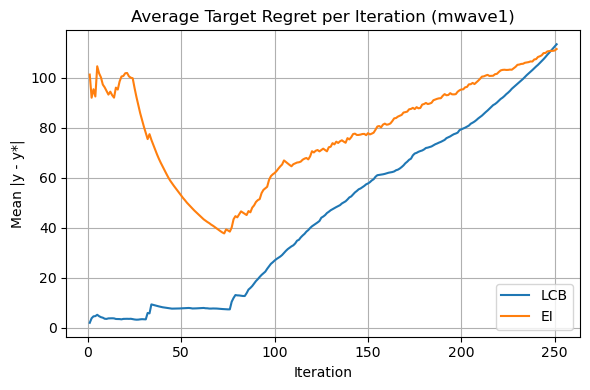

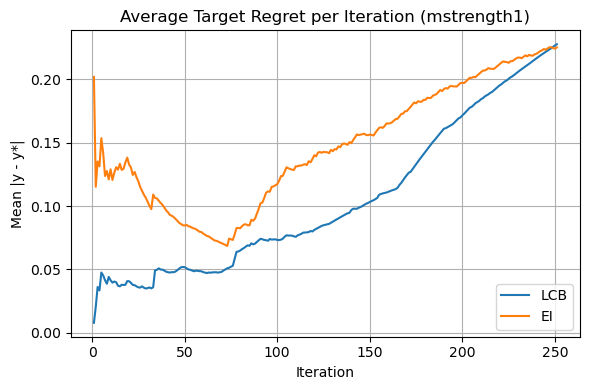

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import GPy
from sklearn.preprocessing import StandardScaler
from scipy.stats import ncx2
import warnings

warnings.filterwarnings("ignore")

def l2_lcb_exact(means: np.ndarray,
                 variances: np.ndarray,
                 target: np.ndarray,
                 p: float = 0.05,
                 eps: float = 1e-8) -> np.ndarray:
    """
    L2-LCB acquisition: returns -lower_bound (larger → more exploratory)
    """
    k      = means.shape[1]
    gamma2 = np.maximum(variances.mean(axis=1), eps)
    diff2  = np.sum((means - target)**2, axis=1)
    lam    = diff2 / gamma2
    q      = ncx2.ppf(1 - p, df=k, nc=lam)
    q      = np.nan_to_num(q, nan=0.0, posinf=0.0, neginf=0.0)
    return -gamma2 * q

def l2_ei(means: np.ndarray,
          variances: np.ndarray,
          target: np.ndarray,
          y_min: float,
          eps: float = 1e-8) -> np.ndarray:
    """
    L2-Expected Improvement acquisition
    """
    k      = means.shape[1]
    gamma2 = np.maximum(variances.mean(axis=1), eps)
    diff2  = np.sum((means - target)**2, axis=1)
    nc     = diff2 / gamma2
    x      = y_min / gamma2
    t1     = y_min * ncx2.cdf(x, df=k,   nc=nc)
    t2     = gamma2 * (
              k   * ncx2.cdf(x, df=k+2, nc=nc)
            + nc  * ncx2.cdf(x, df=k+4, nc=nc)
          )
    return np.maximum(0, t1 - t2)

def fit_multi_gpy(X: np.ndarray, Y: np.ndarray):
    """
    Train an independent GPRegression (Matern52 ARD) for each output.
    """
    models = []
    for i in range(Y.shape[1]):
        kern = GPy.kern.Matern52(input_dim=X.shape[1], ARD=True)
        m    = GPy.models.GPRegression(X, Y[:, [i]], kern)
        m.Gaussian_noise.variance = 1e-6
        m.Gaussian_noise.variance.fix()
        m.optimize(messages=False, max_iters=10)
        models.append(m)
    return models

def predict_multi_gpy(models, X: np.ndarray):
    """
    Returns (means, variances) both shape (n_samples, n_outputs).
    """
    mus, vars_ = [], []
    for m in models:
        mu, var = m.predict(X)
        mus.append(mu.flatten())
        vars_.append(var.flatten())
    return np.column_stack(mus), np.column_stack(vars_)

def compare_cum_target_regret(df: pd.DataFrame,
                              X_cols: list,
                              Y_cols: list,
                              target: np.ndarray,
                              methods=('lcb','ei'),
                              init_size=5,
                              trials=50,
                              p=0.05,
                              budget: int = None):
    """
    Compare methods by cumulative target regret averaged over runs.
    Returns a dict: {method: DataFrame(iteration x objectives)}.
    """
    N = len(df)
    if budget is None:
        budget = N - init_size

    n_obj = len(Y_cols)
    # history[m] shape = (trials, budget, n_obj)
    history = {m: np.zeros((trials, budget, n_obj)) for m in methods}
    Y_all = df[Y_cols].values

    for m in methods:
        for run in range(trials):
            perm       = np.random.permutation(N)
            train_idx  = list(perm[:init_size])
            cand_idx   = list(perm[init_size:])
            cum_regret = np.zeros(n_obj)

            for it in range(budget):
                # Fit model
                Xtr    = df.iloc[train_idx][X_cols].values
                Ytr    = df.iloc[train_idx][Y_cols].values
                scl    = StandardScaler().fit(Ytr)
                Ytr_s  = scl.transform(Ytr)
                tgt_s  = scl.transform(target.reshape(1,-1)).flatten()

                models = fit_multi_gpy(Xtr, Ytr_s)
                Xcand  = df.iloc[cand_idx][X_cols].values
                mus, vars_ = predict_multi_gpy(models, Xcand)

                # Acquisition
                if m == 'lcb':
                    scores = l2_lcb_exact(mus, vars_, tgt_s, p)
                else:
                    y_min   = np.min(np.sum((Ytr_s - tgt_s)**2, axis=1))
                    scores  = l2_ei(mus, vars_, tgt_s, y_min)

                pick     = int(np.argmax(scores))
                idx_pick = cand_idx.pop(pick)
                train_idx.append(idx_pick)

                # Update regret
                y_new       = Y_all[idx_pick]
                cum_regret += np.abs(y_new - target)
                history[m][run, it, :] = cum_regret

    # Average over runs
    df_results = {}
    for m in methods:
        avg = history[m].mean(axis=0)  # shape (budget, n_obj)
        df_m = pd.DataFrame(avg, columns=Y_cols, index=np.arange(1, budget+1))
        df_results[m] = df_m

    return df_results

def plot_avg_target_regret(df_results, Y_cols):
    """
    Plot average regret per iteration / per objective.
    """
    for col in Y_cols:
        plt.figure(figsize=(6,4))
        for method, df_m in df_results.items():
            # Average regret = cumulative regret / iteration
            avg_regret = df_m[col] / df_m.index
            plt.plot(avg_regret.index, avg_regret.values, label=method.upper())
        plt.title(f"Average Target Regret per Iteration ({col})")
        plt.xlabel("Iteration")
        plt.ylabel("Mean |y - y*|")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# --- Example usage ---

X_cols = ["F12","F13","F14","F15","F16","F20","F0",
            "R12","R13","R14","R15","R16","R20","R0"]
Y_cols = ["mwave1","mstrength1"]
target = np.array([330.64, 0.5])

df_res = compare_cum_target_regret(
    df=df_all,
    X_cols=X_cols,
    Y_cols=Y_cols,
    target=target,
    methods=('lcb','ei'),
    init_size=5,
    trials=1,
    p=0.7,
    budget=251
)

# Save CSVs
for method, df_m in df_res.items():
    df_m.div(df_m.index, axis=0).to_csv(
        f"avg_target_regret_{method}.csv"
    )

# Plot
plot_avg_target_regret(df_res, Y_cols)


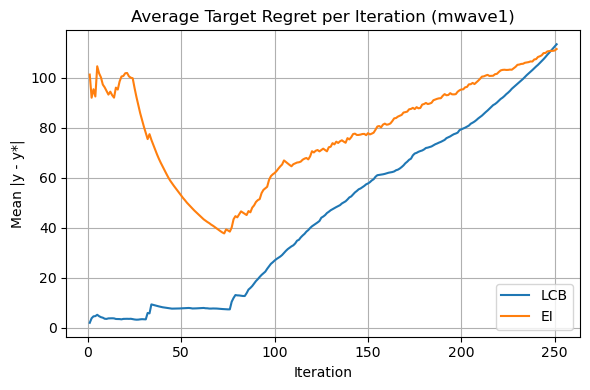

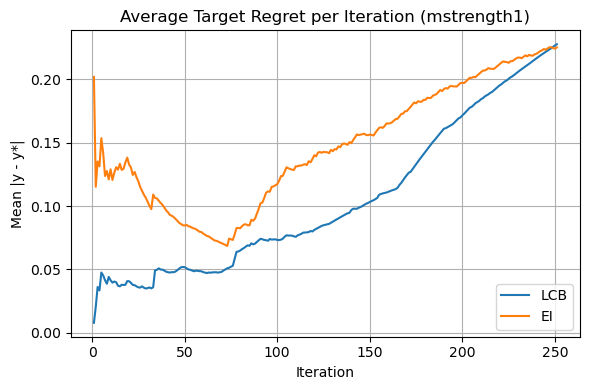

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import GPy
from sklearn.preprocessing import StandardScaler
from scipy.stats import ncx2
import warnings

warnings.filterwarnings("ignore")

def l2_lcb_exact(means: np.ndarray,
                 variances: np.ndarray,
                 target: np.ndarray,
                 p: float = 0.05,
                 eps: float = 1e-8) -> np.ndarray:
    """
    L2-LCB acquisition: returns -lower_bound (larger → more exploratory)
    """
    k      = means.shape[1]
    gamma2 = np.maximum(variances.mean(axis=1), eps)
    diff2  = np.sum((means - target)**2, axis=1)
    lam    = diff2 / gamma2
    q      = ncx2.ppf(1 - p, df=k, nc=lam)
    q      = np.nan_to_num(q, nan=0.0, posinf=0.0, neginf=0.0)
    return -gamma2 * qa

def l2_ei(means: np.ndarray,
          variances: np.ndarray,
          target: np.ndarray,
          y_min: float,
          eps: float = 1e-8) -> np.ndarray:
    """
    L2-Expected Improvement acquisition
    """
    k      = means.shape[1]
    gamma2 = np.maximum(variances.mean(axis=1), eps)
    diff2  = np.sum((means - target)**2, axis=1)
    nc     = diff2 / gamma2
    x      = y_min / gamma2
    t1     = y_min * ncx2.cdf(x, df=k,   nc=nc)
    t2     = gamma2 * (
              k   * ncx2.cdf(x, df=k+2, nc=nc)
            + nc  * ncx2.cdf(x, df=k+4, nc=nc)
          )
    return np.maximum(0, t1 - t2)

def fit_multi_gpy(X: np.ndarray, Y: np.ndarray):
    """
    Train an independent GPRegression (Matern52 ARD) for each output.
    """
    models = []
    for i in range(Y.shape[1]):
        kern = GPy.kern.Matern52(input_dim=X.shape[1], ARD=True)
        m    = GPy.models.GPRegression(X, Y[:, [i]], kern)
        m.Gaussian_noise.variance = 1e-6
        m.Gaussian_noise.variance.fix()
        m.optimize(messages=False, max_iters=10)
        models.append(m)
    return models

def predict_multi_gpy(models, X: np.ndarray):
    """
    Returns (means, variances) both shape (n_samples, n_outputs).
    """
    mus, vars_ = [], []
    for m in models:
        mu, var = m.predict(X)
        mus.append(mu.flatten())
        vars_.append(var.flatten())
    return np.column_stack(mus), np.column_stack(vars_)

def compare_cum_target_regret(df: pd.DataFrame,
                              X_cols: list,
                              Y_cols: list,
                              target: np.ndarray,
                              methods=('lcb','ei'),
                              init_size=5,
                              trials=50,
                              p=0.05,
                              budget: int = None):
    """
    Compare methods by cumulative target regret averaged over runs.
    Returns a dict: {method: DataFrame(iteration x objectives)}.
    """
    N = len(df)
    if budget is None:
        budget = N - init_size

    n_obj = len(Y_cols)
    # history[m] shape = (trials, budget, n_obj)
    history = {m: np.zeros((trials, budget, n_obj)) for m in methods}
    Y_all = df[Y_cols].values

    for m in methods:
        for run in range(trials):
            perm       = np.random.permutation(N)
            train_idx  = list(perm[:init_size])
            cand_idx   = list(perm[init_size:])
            cum_regret = np.zeros(n_obj)

            for it in range(budget):
                # Fit model
                Xtr    = df.iloc[train_idx][X_cols].values
                Ytr    = df.iloc[train_idx][Y_cols].values
                scl    = StandardScaler().fit(Ytr)
                Ytr_s  = scl.transform(Ytr)
                tgt_s  = scl.transform(target.reshape(1,-1)).flatten()

                models = fit_multi_gpy(Xtr, Ytr_s)
                Xcand  = df.iloc[cand_idx][X_cols].values
                mus, vars_ = predict_multi_gpy(models, Xcand)

                # Acquisition
                if m == 'lcb':
                    scores = l2_lcb_exact(mus, vars_, tgt_s, p)
                else:
                    y_min   = np.min(np.sum((Ytr_s - tgt_s)**2, axis=1))
                    scores  = l2_ei(mus, vars_, tgt_s, y_min)

                pick     = int(np.argmax(scores))
                idx_pick = cand_idx.pop(pick)
                train_idx.append(idx_pick)

                # Update regret
                y_new       = Y_all[idx_pick]
                cum_regret += np.abs(y_new - target)
                history[m][run, it, :] = cum_regret

    # Average over runs
    df_results = {}
    for m in methods:
        avg = history[m].mean(axis=0)  # shape (budget, n_obj)
        df_m = pd.DataFrame(avg, columns=Y_cols, index=np.arange(1, budget+1))
        df_results[m] = df_m

    return df_results

def plot_avg_target_regret(df_results, Y_cols):
    """
    Plot average regret per iteration / per objective.
    """
    for col in Y_cols:
        plt.figure(figsize=(6,4))
        for method, df_m in df_results.items():
            # Average regret = cumulative regret / iteration
            avg_regret = df_m[col] / df_m.index
            plt.plot(avg_regret.index, avg_regret.values, label=method.upper())
        plt.title(f"Average Target Regret per Iteration ({col})")
        plt.xlabel("Iteration")
        plt.ylabel("Mean |y - y*|")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# --- Example usage ---

X_cols = ["F12","F13","F14","F15","F16","F20","F0",
            "R12","R13","R14","R15","R16","R20","R0"]
Y_cols = ["mwave1","mstrength1"]
target = np.array([330.64, 0.5])

df_res = compare_cum_target_regret(
    df=df_all,
    X_cols=X_cols,
    Y_cols=Y_cols,
    target=target,
    methods=('lcb','ei'),
    init_size=5,
    trials=1,
    p=0.7,
    budget=251
)

# Save CSVs
for method, df_m in df_res.items():
    df_m.div(df_m.index, axis=0).to_csv(
        f"avg_target_regret_{method}.csv"
    )

# Plot
plot_avg_target_regret(df_res, Y_cols)


# 5.小規模空間で探索

In [18]:
# --- データ読み込み ---
X_cols = ["F12","F13","F14","F15","F16","F20","F0",
        "R12","R13","R14","R15","R16","R20","R0"]
Y_cols = ["dwave1","dstrength1"]
target = np.array([530.64, 0.005])

# --- アクティブラーニング + LOOCV 評価 ---
df_loocv = active_learning_loocv_on_acquired(
    df_medium, df_large,
    X_cols, Y_cols,
    target,
    acquisition='lcb',
    p=0.7,
    budget=150  # 必要なステップ数に応じて
)

# --- 結果保存 & プロット ---
df_loocv.to_csv("loocv_error_by_iteration.csv")
plot_acquired_loocv(df_loocv)


KeyboardInterrupt caught, calling on_optimization_end() to round things up


KeyboardInterrupt: 

# 6.平均累積後悔


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import GPy
from sklearn.preprocessing import StandardScaler
from scipy.stats import ncx2
import warnings

warnings.filterwarnings("ignore")

def l2_lcb_exact(means: np.ndarray,
                 variances: np.ndarray,
                 target: np.ndarray,
                 p: float = 0.05,
                 eps: float = 1e-8) -> np.ndarray:
    k      = means.shape[1]
    gamma2 = np.maximum(variances.mean(axis=1), eps)
    diff2  = np.sum((means - target)**2, axis=1)
    lam    = diff2 / gamma2
    q      = ncx2.ppf(1 - p, df=k, nc=lam)
    q      = np.nan_to_num(q, nan=0.0, posinf=0.0, neginf=0.0)
    return -gamma2 * q

def l2_ei(means: np.ndarray,
          variances: np.ndarray,
          target: np.ndarray,
          y_min: float,
          eps: float = 1e-8) -> np.ndarray:
    k      = means.shape[1]
    gamma2 = np.maximum(variances.mean(axis=1), eps)
    diff2  = np.sum((means - target)**2, axis=1)
    nc     = diff2 / gamma2
    x      = y_min / gamma2
    t1     = y_min * ncx2.cdf(x, df=k,   nc=nc)
    t2     = gamma2 * (
              k   * ncx2.cdf(x, df=k+2, nc=nc)
            + nc  * ncx2.cdf(x, df=k+4, nc=nc)
          )
    return np.maximum(0, t1 - t2)

def fit_multi_gpy(X: np.ndarray, Y: np.ndarray):
    models = []
    for i in range(Y.shape[1]):
        kern = GPy.kern.Exponential(input_dim=X.shape[1], ARD=True)
        m    = GPy.models.GPRegression(X, Y[:, [i]], kern)
        m.Gaussian_noise.variance = 1e-6
        m.Gaussian_noise.variance.fix()
        m.optimize(messages=False, max_iters=10)
        models.append(m)
    return models

def predict_multi_gpy(models, X: np.ndarray):
    mus, vars_ = [], []
    for m in models:
        mu, var = m.predict(X)
        mus.append(mu.flatten())
        vars_.append(var.flatten())
    return np.column_stack(mus), np.column_stack(vars_)

def compare_cum_target_regret(df: pd.DataFrame,
                              X_cols: list,
                              Y_cols: list,
                              target: np.ndarray,
                              methods=('lcb','ei'),
                              init_size=5,
                              trials=50,
                              p=0.05,
                              budget: int = None):
    """
    Compare methods by average per-iteration target regret.
    The initial train set is drawn with RandomState(run+1) for each run,
    and shared between LCB and EI, so both start from the same points.
    Returns: {method: DataFrame(iteration x objectives)}.
    """
    N = len(df)
    if budget is None:
        budget = N - init_size

    n_obj = len(Y_cols)
    # history[m] shape = (trials, budget, n_obj)
    history = {m: np.zeros((trials, budget, n_obj)) for m in methods}
    Y_all = df[Y_cols].values

    for run in range(trials):
        # use a dedicated RNG per run so LCB/EI share the same initial split
        rng        = np.random.RandomState(run + 1)
        perm       = rng.permutation(N)
        train_idx0 = list(perm[:init_size])
        cand_idx0  = list(perm[init_size:])

        for m in methods:
            train_idx  = train_idx0.copy()
            cand_idx   = cand_idx0.copy()
            cum_regret = np.zeros(n_obj)

            for it in range(budget):
                # 1) Fit model on current train_idx
                Xtr    = df.iloc[train_idx][X_cols].values
                Ytr    = df.iloc[train_idx][Y_cols].values
                scl    = StandardScaler().fit(Ytr)
                Ytr_s  = scl.transform(Ytr)
                tgt_s  = scl.transform(target.reshape(1,-1)).flatten()

                models = fit_multi_gpy(Xtr, Ytr_s)
                Xcand  = df.iloc[cand_idx][X_cols].values
                mus, vars_ = predict_multi_gpy(models, Xcand)

                # 2) Acquisition
                if m == 'lcb':
                    scores = l2_lcb_exact(mus, vars_, tgt_s, p)
                else:
                    y_min   = np.min(np.sum((Ytr_s - tgt_s)**2, axis=1))
                    scores  = l2_ei(mus, vars_, tgt_s, y_min)

                pick     = int(np.argmax(scores))
                idx_pick = cand_idx.pop(pick)
                train_idx.append(idx_pick)

                # 3) Update cumulative target regret
                y_new       = Y_all[idx_pick]
                cum_regret += np.abs(y_new - target)

                # 4) Record
                history[m][run, it, :] = cum_regret

    # Average over runs → DataFrames
    df_results = {}
    for m in methods:
        avg = history[m].mean(axis=0)  # shape (budget, n_obj)
        df_m = pd.DataFrame(
            avg,
            columns=Y_cols,
            index=np.arange(1, budget+1)
        )
        df_results[m] = df_m

    return df_results

def plot_avg_target_regret(df_results, Y_cols):
    """
    Plot average regret per iteration / per objective.
    """
    for col in Y_cols:
        plt.figure(figsize=(6,4))
        for method, df_m in df_results.items():
            avg_regret = df_m[col] / df_m.index
            plt.plot(avg_regret.index, avg_regret.values,
                     label=method.upper())
        plt.title(f"Average Target Regret per Iteration ({col})")
        plt.xlabel("Iteration")
        plt.ylabel("Mean |y - y*|")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


# --- load your data here ---
X_cols  = ["F12","F13","F14","F15","F16","F20","F0",
        "R12","R13","R14","R15","R16","R20","R0"]
Y_cols  = ["mwave1","mstrength1"]
target  = np.array([330.64, 0.5])

# compare LCB vs EI
df_res = compare_cum_target_regret(
    df          = df_all,
    X_cols      = X_cols,
    Y_cols      = Y_cols,
    target      = target,
    methods     = ('lcb','ei'),
    init_size   = 5,
    trials      = 10,
    p           = 0.7,
    budget      = 200
)

# save average regrets
for method, df_m in df_res.items():
    df_m.div(df_m.index, axis=0).to_csv(
        f"avg_target_regret_{method}.csv"
    )

# plot
plot_avg_target_regret(df_res, Y_cols)


KeyboardInterrupt: 

In [17]:
# --- load your data here ---
X_cols  = ["F12","F13","F14","F15","F16","F20","F0",
        "R12","R13","R14","R15","R16","R20","R0"]
Y_cols  = ["dwave1","dstrength1"]
target  = np.array([530.64, 0.005])

# compare LCB vs EI
df_res = compare_cum_target_regret(
    df          = df_all,
    X_cols      = X_cols,
    Y_cols      = Y_cols,
    target      = target,
    methods     = ('lcb','ei'),
    init_size   = 5,
    trials      = 100,
    p           = 0.7,
    budget      = 251
)

# save average regrets
for method, df_m in df_res.items():
    df_m.div(df_m.index, axis=0).to_csv(
        f"avg_target_regret_{method}.csv"
    )

# plot
plot_avg_target_regret(df_res, Y_cols)


KeyboardInterrupt caught, calling on_optimization_end() to round things up


KeyboardInterrupt: 

# 7.小を学習　中を候補

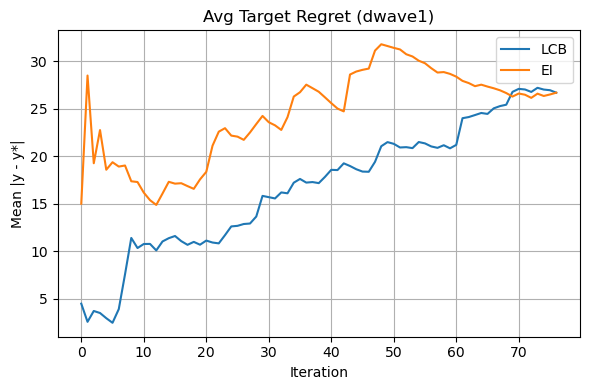

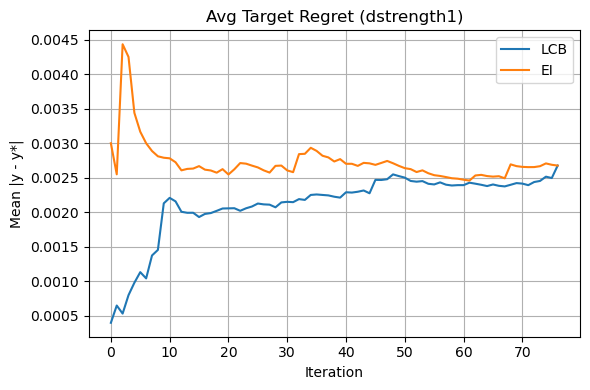

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import GPy
from sklearn.preprocessing import StandardScaler
from scipy.stats import ncx2

def l2_lcb_exact(means: np.ndarray,
                 variances: np.ndarray,
                 target: np.ndarray,
                 p: float = 0.05,
                 eps: float = 1e-8) -> np.ndarray:
    k      = means.shape[1]
    gamma2 = np.maximum(variances.mean(axis=1), eps)
    diff2  = np.sum((means - target)**2, axis=1)
    lam    = diff2 / gamma2
    q      = ncx2.ppf(1 - p, df=k, nc=lam)
    return -gamma2 * np.nan_to_num(q, nan=0.0, posinf=0.0, neginf=0.0)

def l2_ei(means: np.ndarray,
          variances: np.ndarray,
          target: np.ndarray,
          y_min: float,
          eps: float = 1e-8) -> np.ndarray:
    k      = means.shape[1]
    gamma2 = np.maximum(variances.mean(axis=1), eps)
    diff2  = np.sum((means - target)**2, axis=1)
    nc     = diff2 / gamma2
    x      = y_min / gamma2
    t1     = y_min * ncx2.cdf(x, df=k, nc=nc)
    t2     = gamma2 * (k * ncx2.cdf(x, df=k+2, nc=nc) +
                       nc * ncx2.cdf(x, df=k+4, nc=nc))
    return np.maximum(0, t1 - t2)

def fit_multi_gpy(X: np.ndarray, Y: np.ndarray):
    models = []
    for i in range(Y.shape[1]):
        kern = GPy.kern.Exponential(input_dim=X.shape[1], ARD=True)
        m    = GPy.models.GPRegression(X, Y[:, [i]], kern)
        m.Gaussian_noise.variance = 1e-6
        m.Gaussian_noise.variance.fix()
        m.optimize(messages=False, max_iters=10)
        models.append(m)
    return models

def predict_multi_gpy(models, X: np.ndarray):
    mus, vars_ = [], []
    for m in models:
        mu, var = m.predict(X)
        mus.append(mu.flatten())
        vars_.append(var.flatten())
    return np.column_stack(mus), np.column_stack(vars_)

def compare_cum_target_regret_numpy(
    X_train_init: np.ndarray,
    Y_train_init: np.ndarray,
    X_cand_init: np.ndarray,
    Y_cand_init: np.ndarray,
    target: np.ndarray,
    methods=('lcb','ei'),
    trials=30,
    p=0.05,
    budget=None
):
    """
    Pure numpy implementation:
    - X_train_init, Y_train_init: initial training arrays
    - X_cand_init, Y_cand_init: candidate arrays
    - Returns dict of average per-iteration target regret arrays.
    """
    N_cand = X_cand_init.shape[0]
    if budget is None or budget > N_cand:
        budget = N_cand

    n_obj = Y_train_init.shape[1]
    history = {m: np.zeros((trials, budget, n_obj)) for m in methods}

    for run in range(trials):
        # initialize train and candidate arrays
        X_train = X_train_init.copy()
        Y_train = Y_train_init.copy()
        cand_idx = list(range(N_cand))
        cum_regrets = {m: np.zeros(n_obj) for m in methods}

        for m in methods:
            # reset for each method
            X_tr = X_train.copy()
            Y_tr = Y_train.copy()
            idxs = cand_idx.copy()
            cum = np.zeros(n_obj)

            for it in range(budget):
                # scale outputs
                scl    = StandardScaler().fit(Y_tr)
                Y_tr_s = scl.transform(Y_tr)
                tgt_s  = scl.transform(target.reshape(1,-1)).flatten()

                # fit and predict
                models     = fit_multi_gpy(X_tr, Y_tr_s)
                X_cand     = X_cand_init[idxs]
                means, var = predict_multi_gpy(models, X_cand)

                # acquisition
                if m == 'lcb':
                    scores = l2_lcb_exact(means, var, tgt_s, p)
                else:
                    y_min  = np.min(np.sum((Y_tr_s - tgt_s)**2, axis=1))
                    scores = l2_ei(means, var, tgt_s, y_min)

                # select next
                pick = int(np.argmax(scores))
                idx  = idxs.pop(pick)

                # update train sets
                X_new = X_cand_init[idx:idx+1]
                Y_new = Y_cand_init[idx:idx+1]
                X_tr  = np.vstack([X_tr, X_new])
                Y_tr  = np.vstack([Y_tr, Y_new])

                # update regret
                cum += np.abs(Y_cand_init[idx] - target)
                history[m][run, it, :] = cum

    # average over runs and normalize by iteration
    avg_results = {}
    for m in methods:
        avg_cum = history[m].mean(axis=0)  # shape (budget, n_obj)
        avg_reg = avg_cum / np.arange(1, budget+1)[:, None]
        avg_results[m] = avg_reg

    return avg_results

def plot_avg_regret(avg_results, Y_cols):
    for j, col in enumerate(Y_cols):
        plt.figure(figsize=(6,4))
        for m, arr in avg_results.items():
            plt.plot(arr[:, j], label=m.upper())
        plt.title(f"Avg Target Regret ({col})")
        plt.xlabel("Iteration")
        plt.ylabel("Mean |y - y*|")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Example usage:
target = np.array([530.64, 0.005])  # Example target values
X_train, Y_train = df_small[X_cols].values, df_small[y_cols_d].values
X_cand, Y_cand = df_medium[X_cols].values, df_medium[y_cols_d].values
avg_res = compare_cum_target_regret_numpy(
    X_train, Y_train, X_cand, Y_cand, target,
    methods=('lcb','ei'), trials=30, p=0.7, budget=100
)
plot_avg_regret(avg_res, y_cols_d)


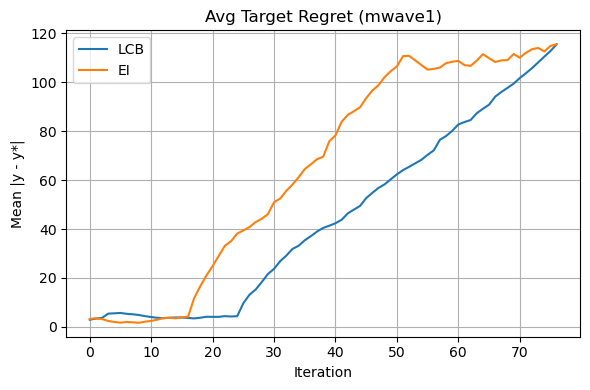

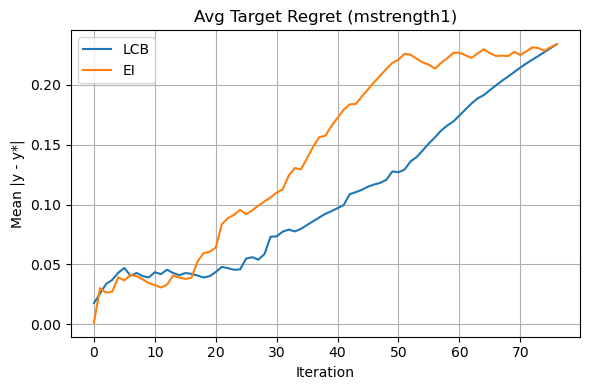

In [14]:
target = np.array([330.64, 0.5])  # Example target values
X_train, Y_train = df_small[X_cols].values, df_small[y_cols_m].values
X_cand, Y_cand = df_medium[X_cols].values, df_medium[y_cols_m].values
avg_res = compare_cum_target_regret_numpy(
    X_train, Y_train, X_cand, Y_cand, target,
    methods=('lcb','ei'), trials=30, p=0.7, budget=100
)
plot_avg_regret(avg_res, y_cols_m)

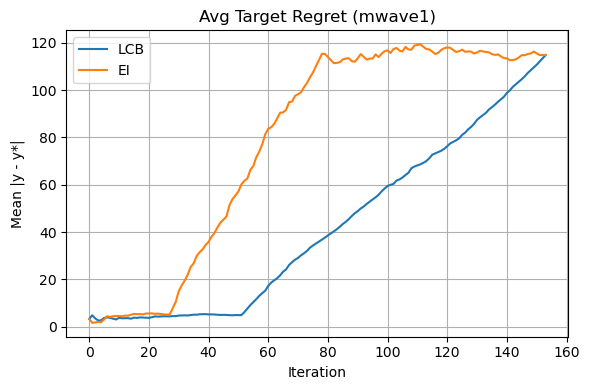

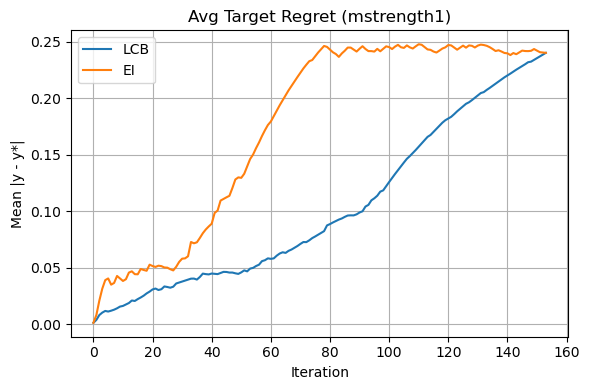

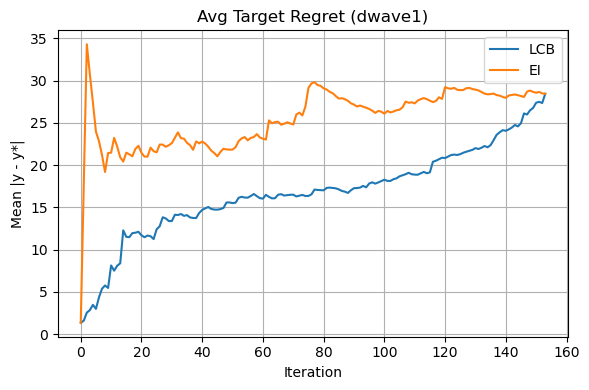

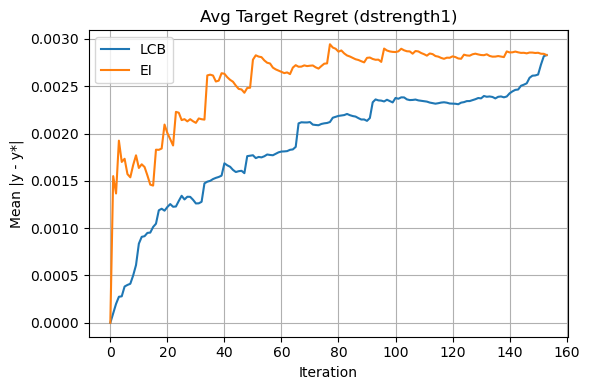

In [16]:
x_train = df_medium[X_cols].values
y_train = df_medium[y_cols_m].values
x_cand = df_large[X_cols].values
y_cand = df_large[y_cols_m].values
target = np.array([330.64, 0.5])  # Example target values
avg_res = compare_cum_target_regret_numpy(
    x_train, y_train, x_cand, y_cand, target,
    methods=('lcb', 'ei'), trials=30, p=0.7, budget=200
)
plot_avg_regret(avg_res, y_cols_m)
x_train = df_medium[X_cols].values
y_train = df_medium[y_cols_d].values
x_cand = df_large[X_cols].values
y_cand = df_large[y_cols_d].values
target = np.array([530.64, 0.005])  # Example target values
avg_res = compare_cum_target_regret_numpy(
    x_train, y_train, x_cand, y_cand, target,
    methods=('lcb', 'ei'), trials=30, p=0.7, budget=200
)
plot_avg_regret(avg_res, y_cols_d)

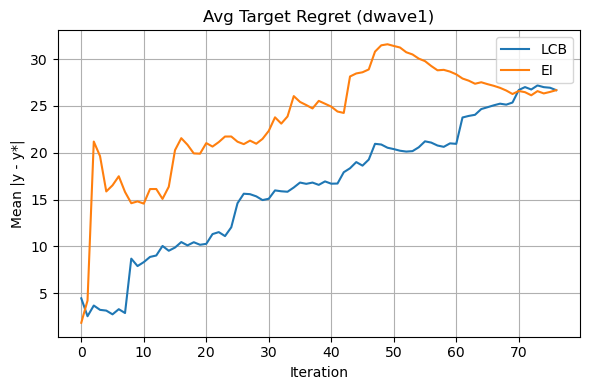

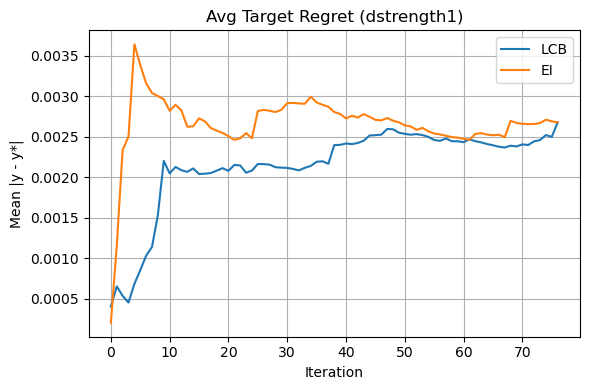

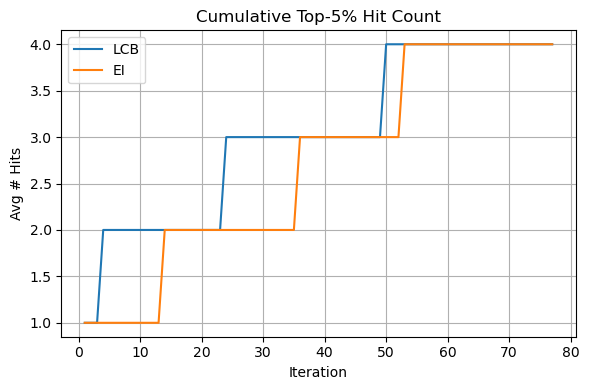

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import GPy
from sklearn.preprocessing import StandardScaler
from scipy.stats import ncx2

def l2_lcb_exact(means: np.ndarray,
                 variances: np.ndarray,
                 target: np.ndarray,
                 p: float = 0.05,
                 eps: float = 1e-8) -> np.ndarray:
    k      = means.shape[1]
    gamma2 = np.maximum(variances.mean(axis=1), eps)
    diff2  = np.sum((means - target)**2, axis=1)
    lam    = diff2 / gamma2
    q      = ncx2.ppf(1 - p, df=k, nc=lam)
    return -gamma2 * np.nan_to_num(q, nan=0.0, posinf=0.0, neginf=0.0)

def l2_ei(means: np.ndarray,
          variances: np.ndarray,
          target: np.ndarray,
          y_min: float,
          eps: float = 1e-8) -> np.ndarray:
    k      = means.shape[1]
    gamma2 = np.maximum(variances.mean(axis=1), eps)
    diff2  = np.sum((means - target)**2, axis=1)
    nc     = diff2 / gamma2
    x      = y_min / gamma2
    t1     = y_min * ncx2.cdf(x, df=k, nc=nc)
    t2     = gamma2 * (k * ncx2.cdf(x, df=k+2, nc=nc)
                       + nc * ncx2.cdf(x, df=k+4, nc=nc))
    return np.maximum(0, t1 - t2)

def fit_multi_gpy(X: np.ndarray, Y: np.ndarray):
    models = []
    for i in range(Y.shape[1]):
        kern = GPy.kern.Exponential(input_dim=X.shape[1], ARD=True)
        m    = GPy.models.GPRegression(X, Y[:, [i]], kern)
        m.Gaussian_noise.variance = 1e-6
        m.Gaussian_noise.variance.fix()
        m.optimize(messages=False, max_iters=10)
        models.append(m)
    return models

def predict_multi_gpy(models, X: np.ndarray):
    mus, vars_ = [], []
    for m in models:
        mu, var = m.predict(X)
        mus.append(mu.flatten())
        vars_.append(var.flatten())
    return np.column_stack(mus), np.column_stack(vars_)

def compare_cum_target_regret_and_hits(
    X_train_init: np.ndarray,
    Y_train_init: np.ndarray,
    X_cand_init: np.ndarray,
    Y_cand_init: np.ndarray,
    target: np.ndarray,
    methods=('lcb','ei'),
    trials=30,
    p=0.05,
    budget=None
):
    """
    Returns two dicts:
      avg_regret[m]: (budget, n_obj) average per-iter target regret
      avg_hits[m]:   (budget,) average cumulative hit-rate for top 5% candidates
    """
    N_cand = X_cand_init.shape[0]
    if budget is None or budget > N_cand:
        budget = N_cand

    # standardize Y_cand for hit-rate threshold
    scaler_global     = StandardScaler().fit(Y_cand_init)
    Y_cand_s          = scaler_global.transform(Y_cand_init)
    target_s_global   = scaler_global.transform(target.reshape(1,-1)).flatten()
    dists             = np.linalg.norm(Y_cand_s - target_s_global, axis=1)
    top_n             = int(np.ceil(0.05 * N_cand))
    threshold         = np.sort(dists)[top_n-1]
    top_idx_set       = set(np.where(dists <= threshold)[0])

    n_obj = Y_train_init.shape[1]
    history_regret = {m: np.zeros((trials, budget, n_obj)) for m in methods}
    history_hits   = {m: np.zeros((trials, budget),   dtype=int) for m in methods}

    for run in range(trials):
        # initialize
        X_train = X_train_init.copy()
        Y_train = Y_train_init.copy()
        cand_idx = list(range(N_cand))
        cum_hits = {m: 0 for m in methods}
        cum_regrets = {m: np.zeros(n_obj) for m in methods}

        for m in methods:
            X_tr = X_train.copy()
            Y_tr = Y_train.copy()
            idxs = cand_idx.copy()
            cum_h = 0
            cum_r = np.zeros(n_obj)

            for it in range(budget):
                # scale outputs
                scl    = StandardScaler().fit(Y_tr)
                Y_tr_s = scl.transform(Y_tr)
                tgt_s  = scl.transform(target.reshape(1,-1)).flatten()

                # fit & predict
                models     = fit_multi_gpy(X_tr, Y_tr_s)
                X_cand     = X_cand_init[idxs]
                mus, vars_ = predict_multi_gpy(models, X_cand)

                # acquisition
                if m=='lcb':
                    scores = l2_lcb_exact(mus, vars_, tgt_s, p)
                else:
                    y_min  = np.min(np.sum((Y_tr_s - tgt_s)**2, axis=1))
                    scores = l2_ei(mus, vars_, tgt_s, y_min)

                # select
                pick    = int(np.argmax(scores))
                idx_sel = idxs.pop(pick)

                # update train
                X_new = X_cand_init[idx_sel:idx_sel+1]
                Y_new = Y_cand_init[idx_sel:idx_sel+1]
                X_tr  = np.vstack([X_tr, X_new])
                Y_tr  = np.vstack([Y_tr, Y_new])

                # update regret
                cum_r += np.abs(Y_cand_init[idx_sel] - target)
                history_regret[m][run, it, :] = cum_r

                # update hits
                if idx_sel in top_idx_set:
                    cum_h += 1
                history_hits[m][run, it] = cum_h

    # compute averages
    avg_regret = {}
    avg_hits   = {}
    for m in methods:
        # average over runs
        avg_r = history_regret[m].mean(axis=0)  # (budget, n_obj)
        avg_regret[m] = avg_r / np.arange(1, budget+1)[:,None]
        avg_hits[m]   = history_hits[m].mean(axis=0)  # (budget,)
    return avg_regret, avg_hits

def plot_avg_regret(avg_regret, Y_cols):
    for j, col in enumerate(Y_cols):
        plt.figure(figsize=(6,4))
        for m, arr in avg_regret.items():
            plt.plot(arr[:,j], label=m.upper())
        plt.title(f"Avg Target Regret ({col})")
        plt.xlabel("Iteration")
        plt.ylabel("Mean |y - y*|")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

def plot_avg_hits(avg_hits):
    plt.figure(figsize=(6,4))
    for m, arr in avg_hits.items():
        plt.plot(np.arange(1, len(arr)+1), arr, label=m.upper())
    plt.title("Cumulative Top-5% Hit Count")
    plt.xlabel("Iteration")
    plt.ylabel("Avg # Hits")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


target = np.array([530.64, 0.005])
Y_cols = ["dwave1", "dstrength1"]

X_train, Y_train = df_small[X_cols].values, df_small[Y_cols].values
X_cand, Y_cand   = df_medium[X_cols].values, df_medium[Y_cols].values
avg_reg, avg_hits = compare_cum_target_regret_and_hits(
    X_train, Y_train, X_cand, Y_cand, target,
    methods=('lcb','ei'), trials=30, p=0.7, budget=100
)

plot_avg_regret(avg_reg, Y_cols)
plot_avg_hits(avg_hits)


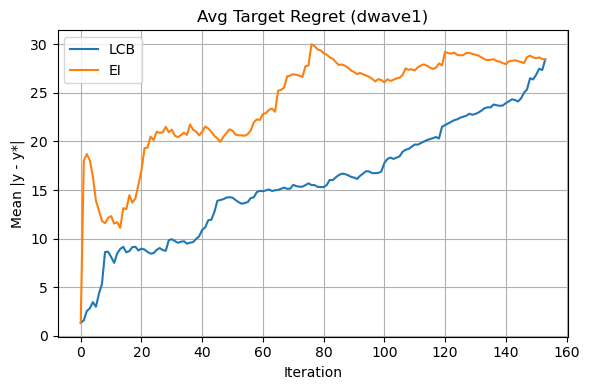

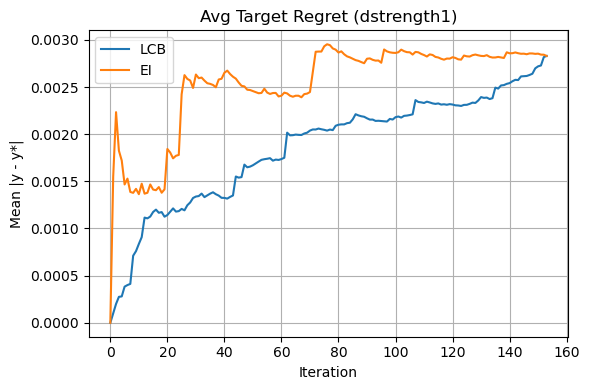

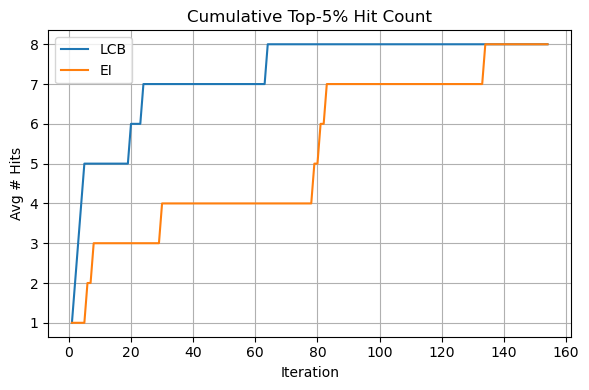

In [22]:

# Example usage:
target = np.array([530.64, 0.005])
X_train, Y_train = df_medium[X_cols].values, df_medium[Y_cols].values
X_cand, Y_cand   = df_large[X_cols].values, df_large[Y_cols].values
avg_reg, avg_hits = compare_cum_target_regret_and_hits(
    X_train, Y_train, X_cand, Y_cand, target,
    methods=('lcb','ei'), trials=1, p=0.7, budget=200
)
plot_avg_regret(avg_reg, Y_cols)
plot_avg_hits(avg_hits)


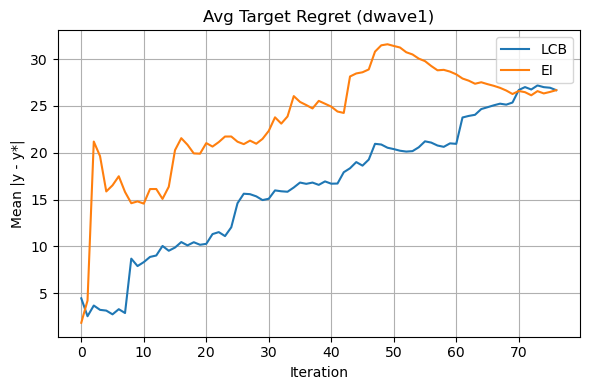

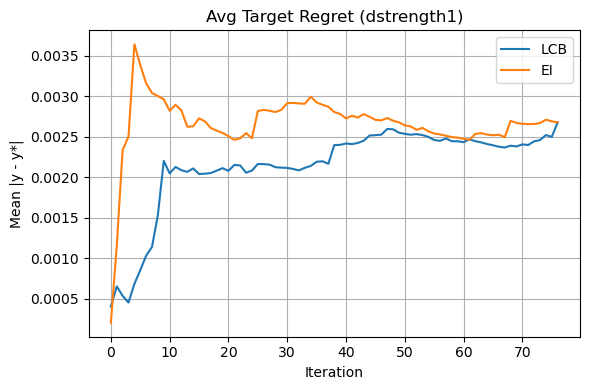

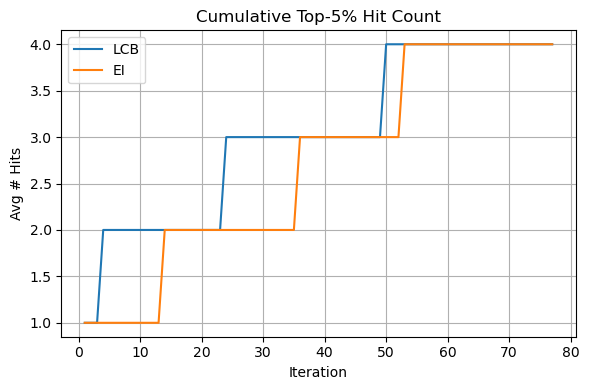

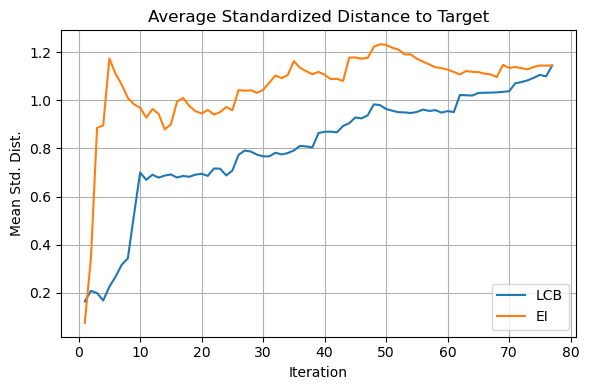

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import GPy
from sklearn.preprocessing import StandardScaler
from scipy.stats import ncx2

def l2_lcb_exact(means: np.ndarray,
                 variances: np.ndarray,
                 target: np.ndarray,
                 p: float = 0.05,
                 eps: float = 1e-8) -> np.ndarray:
    k      = means.shape[1]
    gamma2 = np.maximum(variances.mean(axis=1), eps)
    diff2  = np.sum((means - target)**2, axis=1)
    lam    = diff2 / gamma2
    q      = ncx2.ppf(1 - p, df=k, nc=lam)
    return -gamma2 * np.nan_to_num(q, nan=0.0, posinf=0.0, neginf=0.0)

def l2_ei(means: np.ndarray,
          variances: np.ndarray,
          target: np.ndarray,
          y_min: float,
          eps: float = 1e-8) -> np.ndarray:
    k      = means.shape[1]
    gamma2 = np.maximum(variances.mean(axis=1), eps)
    diff2  = np.sum((means - target)**2, axis=1)
    nc     = diff2 / gamma2
    x      = y_min / gamma2
    t1     = y_min * ncx2.cdf(x, df=k, nc=nc)
    t2     = gamma2 * (k * ncx2.cdf(x, df=k+2, nc=nc) +
                       nc * ncx2.cdf(x, df=k+4, nc=nc))
    return np.maximum(0, t1 - t2)

def fit_multi_gpy(X: np.ndarray, Y: np.ndarray):
    models = []
    for i in range(Y.shape[1]):
        kern = GPy.kern.Exponential(input_dim=X.shape[1], ARD=True)
        m    = GPy.models.GPRegression(X, Y[:, [i]], kern)
        m.Gaussian_noise.variance = 1e-6
        m.Gaussian_noise.variance.fix()
        m.optimize(messages=False, max_iters=10)
        models.append(m)
    return models

def predict_multi_gpy(models, X: np.ndarray):
    mus, vars_ = [], []
    for m in models:
        mu, var = m.predict(X)
        mus.append(mu.flatten())
        vars_.append(var.flatten())
    return np.column_stack(mus), np.column_stack(vars_)

def compare_cum_target_regret_and_hits_dist(
    X_train_init: np.ndarray,
    Y_train_init: np.ndarray,
    X_cand_init: np.ndarray,
    Y_cand_init: np.ndarray,
    target: np.ndarray,
    methods=('lcb','ei'),
    trials=30,
    p=0.05,
    budget=None
):
    """
    Returns three dicts:
      avg_regret[m]: (budget, n_obj) average per-iter target regret
      avg_hits[m]:   (budget,)  average cumulative top-5% hits
      avg_dist[m]:   (budget,)  average cumulative standardized distance
    """
    N_cand = X_cand_init.shape[0]
    if budget is None or budget > N_cand:
        budget = N_cand

    # Precompute standardized distances for hit threshold and dist metric
    scaler_global     = StandardScaler().fit(Y_cand_init)
    Y_cand_s          = scaler_global.transform(Y_cand_init)
    target_s_global   = scaler_global.transform(target.reshape(1,-1)).flatten()
    dists             = np.linalg.norm(Y_cand_s - target_s_global, axis=1)
    top_n             = int(np.ceil(0.05 * N_cand))
    threshold         = np.sort(dists)[top_n-1]
    top_idx_set       = set(np.where(dists <= threshold)[0])

    n_obj = Y_train_init.shape[1]
    history_regret = {m: np.zeros((trials, budget, n_obj)) for m in methods}
    history_hits   = {m: np.zeros((trials, budget), dtype=int) for m in methods}
    history_dist   = {m: np.zeros((trials, budget)) for m in methods}

    for run in range(trials):
        for m in methods:
            X_tr  = X_train_init.copy()
            Y_tr  = Y_train_init.copy()
            idxs  = list(range(N_cand))
            cum_h = 0
            cum_r = np.zeros(n_obj)
            cum_d = 0.0

            for it in range(budget):
                # scale outputs
                scl    = StandardScaler().fit(Y_tr)
                Y_tr_s = scl.transform(Y_tr)
                tgt_s  = scl.transform(target.reshape(1,-1)).flatten()

                # fit & predict
                models     = fit_multi_gpy(X_tr, Y_tr_s)
                X_cand     = X_cand_init[idxs]
                mus, vars_ = predict_multi_gpy(models, X_cand)

                # acquisition
                if m=='lcb':
                    scores = l2_lcb_exact(mus, vars_, tgt_s, p)
                else:
                    y_min   = np.min(((Y_tr_s - tgt_s)**2).sum(axis=1))
                    scores  = l2_ei(mus, vars_, tgt_s, y_min)

                # select next
                pick    = int(np.argmax(scores))
                sel_idx = idxs.pop(pick)

                # update train data
                X_new = X_cand_init[sel_idx:sel_idx+1]
                Y_new = Y_cand_init[sel_idx:sel_idx+1]
                X_tr  = np.vstack([X_tr, X_new])
                Y_tr  = np.vstack([Y_tr, Y_new])

                # regret
                cum_r += np.abs(Y_cand_init[sel_idx] - target)
                history_regret[m][run, it] = cum_r

                # hits
                if sel_idx in top_idx_set:
                    cum_h += 1
                history_hits[m][run, it] = cum_h

                # standardized distance
                cum_d += dists[sel_idx]
                history_dist[m][run, it] = cum_d

    # compute averages and normalize
    avg_regret = {}
    avg_hits   = {}
    avg_dist   = {}
    for m in methods:
        # average cumulative regret normalized per iter
        avg_r = history_regret[m].mean(axis=0)
        avg_regret[m] = avg_r / np.arange(1, budget+1)[:,None]
        # average cumulative hits
        avg_hits[m]   = history_hits[m].mean(axis=0)
        # average cumulative distance normalized per iter
        avg_d         = history_dist[m].mean(axis=0)
        avg_dist[m]   = avg_d / np.arange(1, budget+1)
    return avg_regret, avg_hits, avg_dist

def plot_avg_regret(avg_regret, Y_cols):
    for j, col in enumerate(Y_cols):
        plt.figure(figsize=(6,4))
        for m, arr in avg_regret.items():
            plt.plot(arr[:,j], label=m.upper())
        plt.title(f"Avg Target Regret ({col})")
        plt.xlabel("Iteration")
        plt.ylabel("Mean |y - y*|")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

def plot_avg_hits(avg_hits):
    plt.figure(figsize=(6,4))
    for m, arr in avg_hits.items():
        plt.plot(np.arange(1, len(arr)+1), arr, label=m.upper())
    plt.title("Cumulative Top-5% Hit Count")
    plt.xlabel("Iteration")
    plt.ylabel("Avg # Hits")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_avg_dist(avg_dist):
    plt.figure(figsize=(6,4))
    for m, arr in avg_dist.items():
        plt.plot(np.arange(1, len(arr)+1), arr, label=m.upper())
    plt.title("Average Standardized Distance to Target")
    plt.xlabel("Iteration")
    plt.ylabel("Mean Std. Dist.")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
target = np.array([530.64, 0.005])
X_train, Y_train = df_small[X_cols].values, df_small[Y_cols].values
X_cand, Y_cand   = df_medium[X_cols].values, df_medium[Y_cols].values
avg_reg, avg_hits, avg_dist = compare_cum_target_regret_and_hits_dist(
    X_train, Y_train, X_cand, Y_cand, target,
    methods=('lcb','ei'), trials=1, p=0.7, budget=100
)
plot_avg_regret(avg_reg, Y_cols)
plot_avg_hits(avg_hits)
plot_avg_dist(avg_dist)


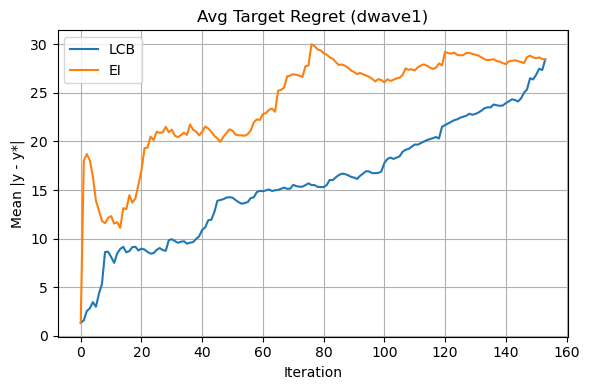

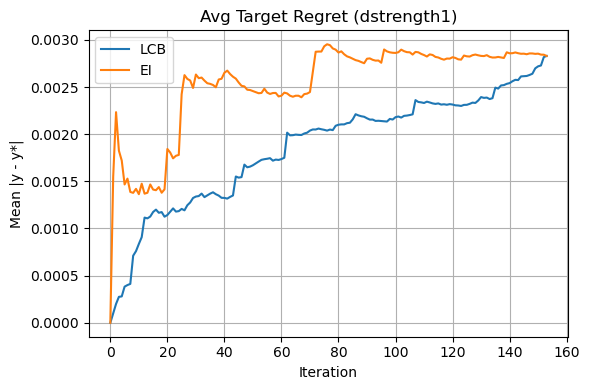

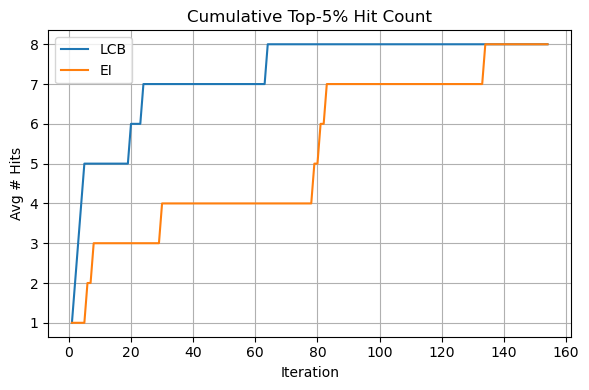

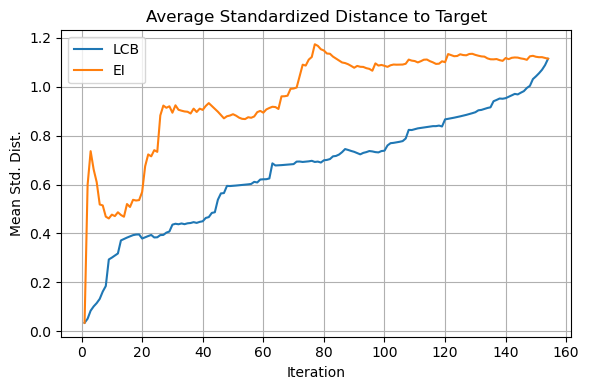

In [26]:
# Example usage:
target = np.array([530.64, 0.005])
X_train, Y_train = df_medium[X_cols].values, df_medium[Y_cols].values
X_cand, Y_cand   = df_large[X_cols].values, df_large[Y_cols].values
avg_reg, avg_hits, avg_dist = compare_cum_target_regret_and_hits_dist(
    X_train, Y_train, X_cand, Y_cand, target,
    methods=('lcb','ei'), trials=1, p=0.7, budget=200
)
plot_avg_regret(avg_reg, Y_cols)
plot_avg_hits(avg_hits)
plot_avg_dist(avg_dist)